In [2]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Parameters
n = 30
C = 10
meanT = [9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7]
meanM = 30
meanM = meanM - 1
VarM = meanM**2
oneItemST = 3

# Parameters of the LOGNORMAL distribution
# The number of items in a customer's cart is a LOGNORMAL random variable
mu = math.log(meanM**2/math.sqrt(VarM+meanM**2))
sigma = math.sqrt(math.log((VarM/meanM**2)+1))


# Factors
p = 0
K = 0

# CSV name
csv_name = "CalibrationLognormal"

In [4]:
print("mu = ", mu)
print("sigma = ", sigma)

mu =  3.0207222397065014
sigma =  0.8325546111576977


In [5]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "vector"], CSV[CSV["attrname"] == "iterationvarsd"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

C:\Users\giova\AppData\Local\Temp\ipykernel_17392\2527533774.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)


In [6]:
print(re.findall(r'\d+\.\d+', "exponential(9.1s,_0)")[0])

9.1


In [7]:

# In the rows where attrname == "iterationvarsd", 
# attrvalue contains the current configuration
# in the following format: exponential(30s,_0)
configurationInfo = CSV[CSV["attrname"] == "iterationvarsd"]

CSV_Vector = CSV[CSV["type"] == "vector"]

# TW: Total Mean Waiting Time [GlobalSink]
Exp_TW = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:vector"]


# Dictionary for containing all the DataFrames
CSV_Dict = {
    "TW": Exp_TW
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in configurationInfo.iterrows():
    # The key of config is the run number and the value is the value of T
    config[row["run"].split("-")[1]] = re.findall(r'\d+\.\d+', row["attrvalue"])[0]


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[1]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            if key == "W":
                PI[key][config[run]][run][string] = row["vecvalue"]

            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][config[run]][run][string] = float(row["value"]) 

        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            if key == "TW":
                PI[key][config[run]][run] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the overall system
                PI[key][config[run]][run] = float(row["value"])


# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific value of T
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [8]:
PI_df["TW"]["9.3"]

,GS
0,0 0 0 0 47.850628376274 0 47.189499882691 48.7...
1,0 0 0 0 0 22.797098368136 9.84018304304 37.751...
2,0 0 38.597675348591 7.202410442907 29.38236974...
3,0 0 0 0 0 0 37.784478679791 0 0 53.46483418377...
4,0 0 0 18.503784307215 58.904001890245 0 0 9.65...
5,0 0 0 0 0 36.677351289625 0 0 17.123824296117 ...
6,0 0 47.264789791187 0 51.729358181729 48.51234...
7,0 0 0 39.066023967946 0 28.407846825123 0 0 72...
8,0 35.756581454843 0 0 0 0 107.4949850861 101.4...
9,0 0 0 0 58.083231518685 113.90413816839 0 0 15...


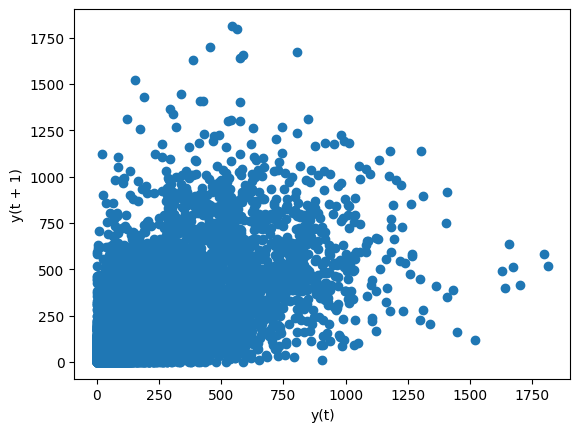

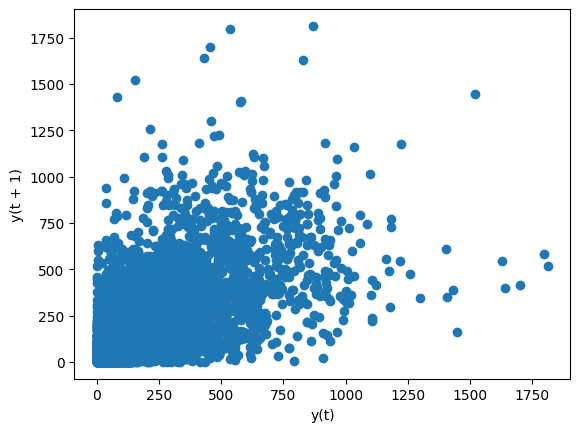

C:\Users\giova\AppData\Local\Temp\ipykernel_17392\1662802151.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(values, hist=False, rug=True)


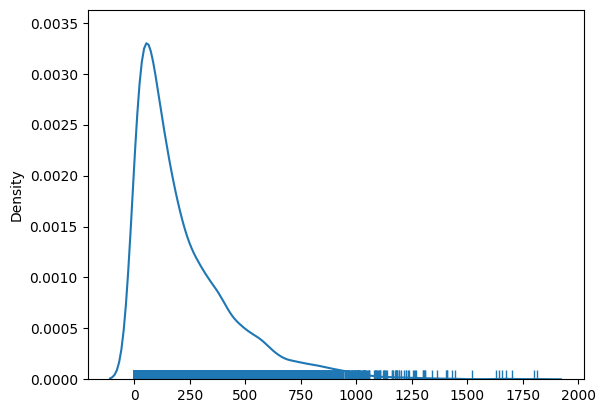

In [9]:
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import lag_plot

values = PI_df["TW"]["9.3"]["GS"].iloc[0]
values = values.split(" ")
values = [float(i) for i in values]
values = pd.DataFrame(values)
lag_plot(values)
plt.show()
subsample = values.sample(frac=0.5)
subsample.sort_index(inplace=True)
lag_plot(subsample)
plt.show()
sns.distplot(values, hist=False, rug=True)
plt.show()

In [10]:

for t in meanT:
   for index, row in PI_df["TW"][str(t)].iterrows():
        values = row["GS"].split(" ")
        values = [float(v) for v in values]
        values = pd.DataFrame(values)
        PI_df["TW"][str(t)].loc[index, "GS"] = values.mean()[0]



In [11]:
PI_df["TW"]["9.3"]

,GS
0,221.917123
1,275.875226
2,152.884693
3,143.287176
4,381.108327
5,314.072651
6,190.498605
7,172.064018
8,427.394262
9,418.180237


C:\Users\giova\AppData\Local\Temp\ipykernel_17392\3292139197.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(PI_df["TW"]["9.2"]["GS"], hist=False, rug=True)


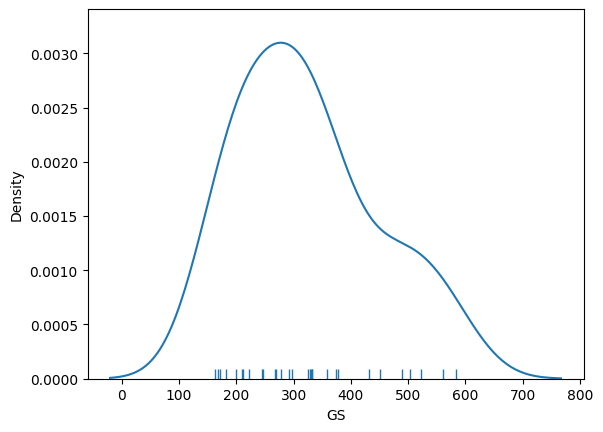

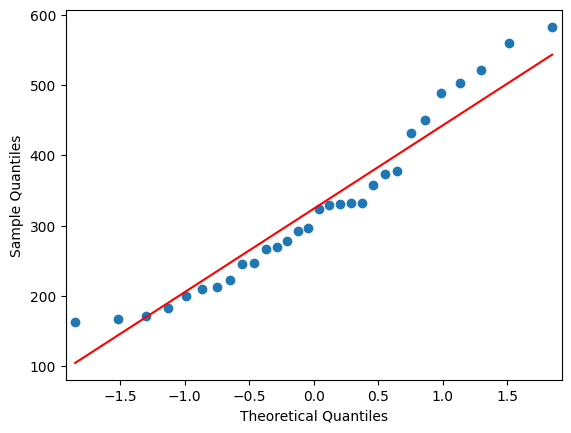

In [12]:
from statsmodels.graphics.gofplots import qqplot

sns.distplot(PI_df["TW"]["9.2"]["GS"], hist=False, rug=True)
plt.show()
qqplot(PI_df["TW"]["9.2"]["GS"], line='s')
plt.show()

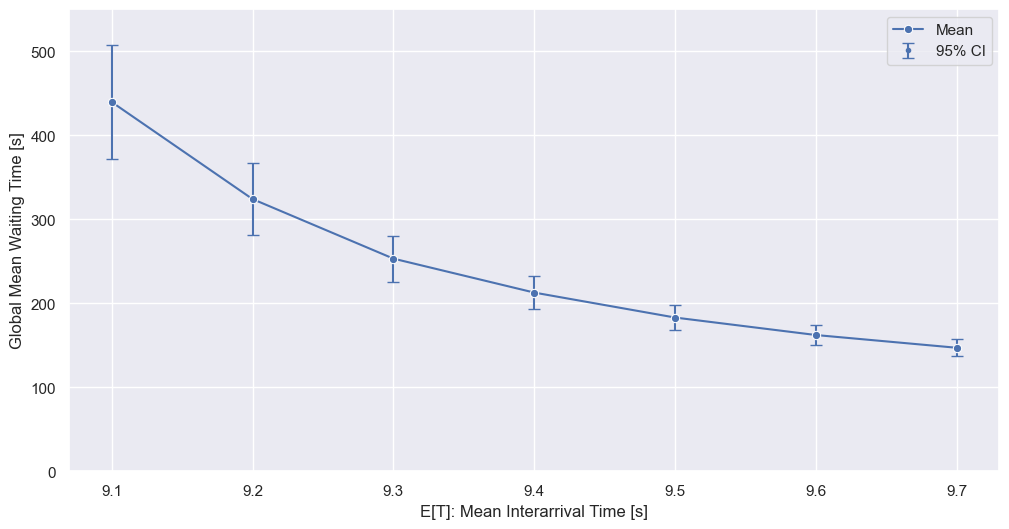

225.79949662081196
253.03283524775688
280.2661738747018


In [13]:
# (Normal)
# Second Calibration

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

y_V = []

ci = []
# Confidence Interval Bounds
ci_lb = []
ci_ub = []

for t in meanT:
    
    # We save in y_V the mean value for the current t
    y_V.append(PI_df[pi][str(t)]["GS"].mean())

    ci.append(1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n)))
    # We compute the confidence interval bounds
    ci_lb.append(PI_df[pi][str(t)]["GS"].mean() - (1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n))))
    ci_ub.append(PI_df[pi][str(t)]["GS"].mean() + (1.96 * (PI_df[pi][str(t)]["GS"].std() / math.sqrt(n))))

# We plot the confidence intervals
# plt.fill_between(meanT, ci_lb, ci_ub, alpha=0.1, label="95% CI")

# We plot the error bars
plt.errorbar(x=meanT, y=y_V, fmt='o', yerr=ci, markersize=3, capsize=4, color='b', label="95% CI")

# We plot the line for the current p_
sns.lineplot(x=meanT, y=y_V, marker='o', label="Mean")

# Set the x-axis limits
# plt.xlim(0, 45)  
# Set the y-axis limits
plt.ylim(0, 550)  

# plt.title('Second Calibration with 95% CI [Zoomed]')
plt.xlabel('E[T]: Mean Interarrival Time [s]')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

print(ci_lb[2])
print(y_V[2])
print(ci_ub[2])

In [14]:
pi = "TW"
P_LOG = {}
P_LOG[pi] = {}

for t in meanT:
    P_LOG[pi][str(t)] = pd.DataFrame(columns=["GS"])
    P_LOG[pi][str(t)]["GS"] = np.log(PI_df[pi][str(t)]["GS"].values.astype(np.float64).tolist())

P_LOG["TW"]["9.1"]

,GS
0,5.804189
1,6.199578
2,5.265318
3,5.256760
4,6.736740
5,6.092987
6,5.927874
7,5.601050
8,6.625079
9,6.511078


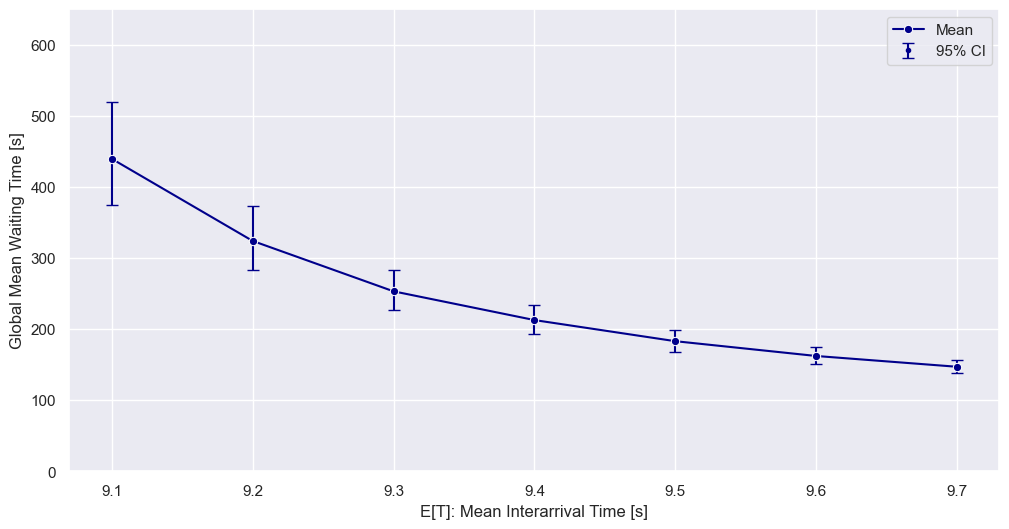

283.0227405156684
323.95435187352973
372.8095136194937


In [23]:
# (Cox-Method)
# Second Calibration

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

y_V = []

ci_AA = []
ci_BB = []
# Confidence Interval Bounds
ci_lb = []
ci_ub = []

for t in meanT:
    
    # We save in y_V the mean value for the current t
    y_V.append(PI_df[pi][str(t)]["GS"].mean())

    ci_AA.append(PI_df[pi][str(t)]["GS"].mean() - np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))))
    ci_BB.append(np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))) - PI_df[pi][str(t)]["GS"].mean())

    # We compute the confidence interval bounds
    # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
    ci_lb.append(np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))))
    ci_ub.append(np.exp(P_LOG[pi][str(t)]["GS"].mean() + (P_LOG[pi][str(t)]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][str(t)]["GS"].std()**2 / n) + (P_LOG[pi][str(t)]["GS"].std()**4 / (2 * (n-1)))))))


# We plot the confidence intervals
# plt.fill_between(meanT, ci_lb, ci_ub, alpha=0.1, label="95% CI")

# We plot the error bars
plt.errorbar(x=meanT, y=y_V, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=4, color='darkblue', label="95% CI")

# We plot the line for the current p_
sns.lineplot(x=meanT, y=y_V, marker='o', label="Mean", color='darkblue')

# Set the x-axis limits
# plt.xlim(0, 45)  
# Set the y-axis limits
plt.ylim(0, 650)  

# plt.title('Second Calibration with 95% CI [Zoomed]')
plt.xlabel('E[T]: Mean Interarrival Time [s]')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

print(ci_lb[1])
print(y_V[1])
print(ci_ub[1])